In [14]:
import json
import numpy as np
import pandas as pd
import os
import math

In [26]:
def load_scores(mat_path, n_queries):
    mat = np.fromfile(mat_path, dtype=np.float32)[4:]
    n_targets = len(mat) // n_queries
    return mat.reshape(n_queries, n_targets)    

In [27]:
def load_files(expected_rows, mat_path, features_path):
    features = json.load(open(features_path))
    mat = load_scores(mat_path, expected_rows)
    np.fill_diagonal(mat, mat.min() - 1) # self dist is not interesting!
    prob_ids = np.array(features['id'])
    return mat, prob_ids

In [28]:
def dist_fuse(mat_1, mat_2):
    return (mat_1 + mat_2) / 2

In [29]:
def top1(mat, prob_ids):
    """ 
        is the target id in the top 1 (not including self image)
        (prob_mat assuming diag is nan)
        prob_ids are a ground truth of ids ordered probmat and distmat entries
    """
    
    top_scores = np.max(mat, axis=1)
    top_labels = np.argmax(mat, axis=1) # indices
    top_labels = prob_ids[top_labels]
    
    return top_labels, top_scores

In [30]:
def topk(mat, prob_ids, k):
    """ 
        is the target id in the top 1 (not including self image)
        (prob_mat assuming diag is nan)
        prob_ids are a ground truth of ids ordered probmat entries
    """
    
    out_max_k = -np.partition(-mat, k, axis=1)[:, :k] # best out of distractor set
    out_max_labels_k = np.argpartition(-mat, k, axis=1)[:, :k] # best out of distractor set
    out_max_labels_k = prob_ids[out_max_labels_k]
    
    return out_max_labels_k, out_max_k

In [ ]:
def rank1_(mat, prob_ids):
    """ 
        is the target id in the top 1 (not including self image)
        (prob_mat assuming diag is nan)
        prob_ids are a ground truth of ids ordered probmat entries
    """
    
    n_probs = mat.shape[1]
    inf_ = mat.min() - 1
    score = 0
    n_query = 0 
    for query_id in set(prob_ids):
        # probes from iden
        row_mask = list((query_id == prob_ids))
        curr_id_mat = mat[row_mask, :].copy()
        
        n_id_probs, n_probs_and_one_other = curr_id_mat.shape
        query_indices = np.argwhere(row_mask).T[0]
        for row_i, col_i in enumerate(query_indices):
            # nullify all other cols from indices
            col_mask = row_mask.copy()
            col_mask[col_i] = False

            other_probs_sub = curr_id_mat[: , col_mask].copy()
            curr_id_mat[: , col_mask] = inf_

            # calc hits
            top_hits = np.delete(np.argmax(curr_id_mat, axis=1), row_i ,0)
            top_id = prob_ids[top_hits]
            score += sum(top_id == query_id)
            n_query += len(top_id)
            
    return score/n_query

In [32]:
def open_set_label_and_score(mat, prob_ids):
    """
         What is the 2nd iden for the prob if he is not in set?
         What is it's score?
    """
    
    indexes = np.unique(prob_ids, return_index=True)[1]  # ids sorted by apperance
    id_set = [prob_ids[index] for index in sorted(indexes)]
    res_label = []
    res_score = []
    inf_ = mat.min() - 1
    for curr_id in id_set:
        # nullify all query cols from indices
        row_mask = list(curr_id == prob_ids)
        curr_prob_mat = mat[row_mask, :].copy()
        curr_prob_mat[: , row_mask] = inf_
        
        label, scores = top1(curr_prob_mat, prob_ids)
        res_label.extend(label)
        res_score.extend(scores)
    return np.array(res_label), np.array(res_score)

In [33]:
def open_set_label_and_score_topk(mat, prob_ids):
    """
         What is the 2nd iden for the prob if he is not in set?
         What is it's score?
    """
    
    indexes = np.unique(prob_ids, return_index=True)[1]  # ids sorted by apperance
    id_set = [prob_ids[index] for index in sorted(indexes)]
    res_label = []
    res_score = []
    inf_ = mat.min() - 1
    for curr_id in id_set:
        # nullify all query cols from indices
        row_mask = list(curr_id == prob_ids)
        curr_prob_mat = mat[row_mask, :].copy()
        curr_prob_mat[: , row_mask] = inf_
        
        label, scores = topk(mat, prob_ids, 3)
        res_label.append(label)
        res_score.append(scores)
    return np.vstack(res_label), np.vstack(res_score)

In [34]:
def model_agreement(mat_0, mat_1, prob_ids):
    open_set_k_labels_0, open_set_k_scores_0  = open_set_label_and_score_topk(mat_0, prob_ids)
    open_set_k_labels_1, open_set_k_scores_1 = open_set_label_and_score_topk(mat_1, prob_ids)

    a = 0
    for row_0, row_1 in zip(open_set_k_labels_0, open_set_k_labels_1):
        a+= (len(np.intersect1d(row_0, row_1)) > 0)
    b = len(prob_ids)
    print('\n any(2nd,3rd,4th) iden Corr=%0.1f%% \n' % (100.0*a / b) )

In [35]:
def agreement_models(mat_0, mat_1, prob_ids):
    print('Agreement model')
    top1_labels_0, top1_scores_0 = top1(mat_0, prob_ids)
    top1_labels_1, top1_scores_1 = top1(mat_1, prob_ids)

    open_set_1st_labels_0, open_set_1st_scores_0  = open_set_label_and_score(mat_0, prob_ids)
    open_set_1st_labels_1, open_set_1st_scores_1 = open_set_label_and_score(mat_1, prob_ids)
    
    a = np.sum((open_set_1st_labels_0 == open_set_1st_labels_1))
    b = mat_0.shape[0]
    print('2nd iden Corr=%0.1f%%' % (100.0*a / b) )

    target_FTRS = [0.0001, 0.01, 0.1, 0.2, 0.3]
    thresholds = np.unique(np.concatenate((top1_scores_0,top1_scores_1,
                                              open_set_1st_scores_0, open_set_1st_scores_1)))

    models_agree = (open_set_1st_labels_0 == open_set_1st_labels_1)
    FTRs = [np.sum(models_agree & (open_set_1st_scores_0 > TH) & (open_set_1st_scores_1 > TH)) / b
            for TH in thresholds]
    
    mod_0_corr = (top1_labels_0 == prob_ids)
    mod_1_corr = (top1_labels_1 == prob_ids)
    TTRs = [np.sum( (top1_scores_0 > TH) &
                    (top1_scores_1 > TH) &
                     mod_0_corr &
                     mod_1_corr ) / b for TH, FTR in zip(thresholds, FTRs)]

    for target_FTR in target_FTRS:
        if (FTRs[0] <= target_FTR):
            print('FTR=%0.1f%%, TTR=%0.1f%%' % (target_FTR * 100, TTRs[0] * 100))
            continue
        for TH, FTR, TTR in zip(thresholds, FTRs, TTRs):
            if math.isclose(FTR, target_FTR, abs_tol = 0.001):
                print('FTR=%0.1f%%, TTR=%0.1f%%' % (FTR * 100, TTR * 100))
                break
        
    return np.array(thresholds), np.array(FTRs), np.array(TTRs)

In [36]:
def dist_fuse_models(mat_0, mat_1, prob_ids):
    print('\nDist_fuse model')
    rank1_0 = rank1_(mat_0, prob_ids)
    rank1_1 = rank1_(mat_1, prob_ids)
    mat = dist_fuse(mat_0, mat_1)
    rank1_fuse = rank1_(mat, prob_ids)
    
    print('Rank-1:\n model0:{} \n model1:{} \n mean_fuse:{}'.format(rank1_0, rank1_1, rank1_fuse))
    
    top1_labels, top1_scores = top1(mat, prob_ids)
    open_set_1st_labels, open_set_1st_scores = open_set_label_and_score(mat, prob_ids)

    target_FTRS = [0.0001, 0.01, 0.1, 0.2, 0.3]
    thresholds = np.unique(np.concatenate((top1_scores, open_set_1st_scores)))

    FTRs = [np.sum((open_set_1st_scores > TH)) / mat_0 for TH in thresholds]
    mod_corr = (top1_labels == prob_ids)
    TTRs = [np.sum( (top1_scores > TH) &
                     mod_corr) / mat_0.shape[0] for TH, FTR in zip(thresholds, FTRs)]

    for target_FTR in target_FTRS:
        if (FTRs[0] <= target_FTR):
            print('FTR=%0.1f%%, TTR=%0.1f%%' % (target_FTR * 100, TTRs[0] * 100))
            continue
        for TH, FTR, TTR in zip(thresholds, FTRs, TTRs):
            if math.isclose(FTR, target_FTR, abs_tol = 0.001):
                print('FTR=%0.1f%%, TTR=%0.1f%%' % (FTR * 100, TTR * 100))
                break
        
    return np.array(thresholds), np.array(FTRs), np.array(TTRs)

In [37]:
def get_verification(cmc_path, idx):
    cmc = json.load(open(cmc_path))
    for TH, acc in zip(*cmc['roc']):
        if math.isclose(TH, 1e-6, abs_tol = 1e-6) and TH > 1e-6:
            print('Verification %d: %0.4f%%' % (idx, acc))
            break

In [40]:
# baseline

# TODO filter rows with only one iden
expected_rows = 13183
mat_path = "results_lfw/base_0/otherFiles/lfw_lfw_base_0.bin"
features_path = "results_lfw/base_0/otherFiles/lfw_features_base_0"
mat_0, prob_ids = load_files(expected_rows, mat_path, features_path)

mat_path = "results_lfw/base_1/otherFiles/lfw_lfw_base_1.bin"
features_path = "results_lfw/base_1/otherFiles/lfw_features_base_1"
mat_1, prob_ids = load_files(expected_rows, mat_path, features_path)

baseline_thresholds, baseline_FTRs, baseline_TTR = agreement_models(mat_0, mat_1, prob_ids)
fuse_baseline_thresholds, fuse_baseline_FTRs, fuse_baseline_TTR = dist_fuse_models(mat_0, mat_1, prob_ids)

Agreement model
2nd iden Corr=43.4%
FTR=0.1%, TTR=26.7%
FTR=1.1%, TTR=67.2%
FTR=10.1%, TTR=69.0%
FTR=20.1%, TTR=69.0%
FTR=30.1%, TTR=69.0%

Dist_fuse model
Rank-1:
 model0:0.015275495627905441 
 model1:0.015271367115573574 
 mean_fuse:0.015275495627905441


KeyboardInterrupt: 

In [147]:
# pearson.5
match_path = "results_lfw/pearson.5_0/matches_facescrub_lfw_funneled_aligned_pearson_13045_1.json"
distractor_mat_path = "results_lfw/pearson.5_0/otherFiles/facescrub_lfw_funneled_aligned_pearson_13045_1.bin"
prob_mat_path = "results_lfw/pearson.5_0/otherFiles/facescrub_facescrub_pearson.bin"
features_path = "results_lfw/pearson.5_0/otherFiles/facescrub_features_pearson"
dist_features_path = "results_lfw/pearson.5_0/otherFiles/lfw_funneled_aligned_features_pearson_13045_1"

prob_mat_0, distractor_mat_0, prob_ids = load_files(match_path, distractor_mat_path, prob_mat_path, features_path, dist_features_path)

match_path = "results_lfw/pearson.5_1/matches_facescrub_lfw_funneled_aligned_pearson_13045_1.json"
distractor_mat_path = "results_lfw/pearson.5_1/otherFiles/facescrub_lfw_funneled_aligned_pearson_13045_1.bin"
prob_mat_path = "results_lfw/pearson.5_1/otherFiles/facescrub_facescrub_pearson.bin"
features_path = "results_lfw/pearson.5_1/otherFiles/facescrub_features_pearson"
dist_features_path = "results_lfw/pearson.5_1/otherFiles/lfw_funneled_aligned_features_pearson_13045_1"

prob_mat_1, distractor_mat_1, prob_ids = load_files(match_path, distractor_mat_path, prob_mat_path, features_path, dist_features_path)
p5_thresholds, p5_FTRs, p5_TTR = agreement_models(prob_mat_0, distractor_mat_0, prob_mat_1, distractor_mat_1, prob_ids)
fuse_p5_thresholds, fuse_p5_FTRs, fuse_p5_TTR = dist_fuse_models(prob_mat_0, distractor_mat_0, prob_mat_1, distractor_mat_1, prob_ids)

Agreement model
2nd iden Corr=47.3%
FTR=0.1%, TTR=27.2%
FTR=1.1%, TTR=58.4%
FTR=10.1%, TTR=89.0%
FTR=20.1%, TTR=96.7%
FTR=30.1%, TTR=98.9%

Dist_fuse model
Rank-1:
 model0:0.8032294677383167 
 model1:0.8015797600665162 
 mean_fuse:0.8059283894893825
FTR=0.1%, TTR=25.7%
FTR=1.1%, TTR=57.4%
FTR=10.1%, TTR=87.4%
FTR=20.1%, TTR=95.3%
FTR=30.1%, TTR=98.7%


In [148]:
# pearson.75
match_path = "results_lfw/pearson.75_0/matches_facescrub_lfw_funneled_aligned_pearson_13045_1.json"
distractor_mat_path = "results_lfw/pearson.75_0/otherFiles/facescrub_lfw_funneled_aligned_pearson_13045_1.bin"
prob_mat_path = "results_lfw/pearson.75_0/otherFiles/facescrub_facescrub_pearson.bin"
features_path = "results_lfw/pearson.75_0/otherFiles/facescrub_features_pearson"
dist_features_path = "results_lfw/pearson.75_0/otherFiles/lfw_funneled_aligned_features_pearson_13045_1"

prob_mat_0, distractor_mat_0, prob_ids = load_files(match_path, distractor_mat_path, prob_mat_path, features_path, dist_features_path)

match_path = "results_lfw/pearson.75_1/matches_facescrub_lfw_funneled_aligned_pearson_13045_1.json"
distractor_mat_path = "results_lfw/pearson.75_1/otherFiles/facescrub_lfw_funneled_aligned_pearson_13045_1.bin"
prob_mat_path = "results_lfw/pearson.75_1/otherFiles/facescrub_facescrub_pearson.bin"
features_path = "results_lfw/pearson.75_1/otherFiles/facescrub_features_pearson"
dist_features_path = "results_lfw/pearson.75_1/otherFiles/lfw_funneled_aligned_features_pearson_13045_1"

prob_mat_1, distractor_mat_1, prob_ids = load_files(match_path, distractor_mat_path, prob_mat_path, features_path, dist_features_path)
p75_thresholds, p75_FTRs, p75_TTR = agreement_models(prob_mat_0, distractor_mat_0, prob_mat_1, distractor_mat_1, prob_ids)
fuse_p75_thresholds, fuse_p75_FTRs, fuse_p75_TTR = fuse_models(prob_mat_0, distractor_mat_0, prob_mat_1, distractor_mat_1, prob_ids)

Agreement model
2nd iden Corr=39.9%
FTR=0.1%, TTR=22.6%
FTR=1.1%, TTR=55.0%
FTR=10.1%, TTR=88.8%
FTR=20.1%, TTR=96.8%
FTR=30.1%, TTR=98.8%
Rank-1:
 model0:0.8014807776062082 
 model1:0.7934829948133191 
 mean_fuse:0.8028665320505206

 2nd iden Corr=39.9% 

FTR=0.1%, TTR=22.6%
FTR=1.1%, TTR=55.0%
FTR=10.1%, TTR=88.8%
FTR=20.1%, TTR=96.8%
FTR=30.1%, TTR=98.8%


In [149]:
# pearson.9
match_path = "results_lfw/pearson.9_0/matches_facescrub_lfw_funneled_aligned_pearson_13045_1.json"
distractor_mat_path = "results_lfw/pearson.9_0/otherFiles/facescrub_lfw_funneled_aligned_pearson_13045_1.bin"
prob_mat_path = "results_lfw/pearson.9_0/otherFiles/facescrub_facescrub_pearson.bin"
features_path = "results_lfw/pearson.9_0/otherFiles/facescrub_features_pearson"
dist_features_path = "results_lfw/pearson.9_0/otherFiles/lfw_funneled_aligned_features_pearson_13045_1"

prob_mat_0, distractor_mat_0, prob_ids = load_files(match_path, distractor_mat_path, prob_mat_path, features_path, dist_features_path)

match_path = "results_lfw/pearson.9_1/matches_facescrub_lfw_funneled_aligned_pearson_13045_1.json"
distractor_mat_path = "results_lfw/pearson.9_1/otherFiles/facescrub_lfw_funneled_aligned_pearson_13045_1.bin"
prob_mat_path = "results_lfw/pearson.9_1/otherFiles/facescrub_facescrub_pearson.bin"
features_path = "results_lfw/pearson.9_1/otherFiles/facescrub_features_pearson"
dist_features_path = "results_lfw/pearson.9_1/otherFiles/lfw_funneled_aligned_features_pearson_13045_1"

prob_mat_1, distractor_mat_1, prob_ids = load_files(match_path, distractor_mat_path, prob_mat_path, features_path, dist_features_path)
p9_thresholds, p9_FTRs, p9_TTR = agreement_models(prob_mat_0, distractor_mat_0, prob_mat_1, distractor_mat_1, prob_ids)
fuse_p9_thresholds, fuse_p9_FTRs, fuse_p9_TTR = dist_fuse_models(prob_mat_0, distractor_mat_0, prob_mat_1, distractor_mat_1, prob_ids)

Agreement model
2nd iden Corr=36.8%
FTR=0.1%, TTR=25.8%
FTR=1.1%, TTR=56.0%
FTR=10.1%, TTR=88.8%
FTR=20.1%, TTR=96.9%
FTR=30.1%, TTR=98.8%

Dist_fuse model
Rank-1:
 model0:0.7841588470523023 
 model1:0.7920312520621345 
 mean_fuse:0.7998508664264692
FTR=0.1%, TTR=23.9%
FTR=1.1%, TTR=55.5%
FTR=10.1%, TTR=87.6%
FTR=20.1%, TTR=96.3%
FTR=30.1%, TTR=98.6%


In [150]:
# mean.1
match_path = "results_lfw/mean.1_0/matches_facescrub_lfw_funneled_aligned_mean_13045_1.json"
distractor_mat_path = "results_lfw/mean.1_0/otherFiles/facescrub_lfw_funneled_aligned_mean_13045_1.bin"
prob_mat_path = "results_lfw/mean.1_0/otherFiles/facescrub_facescrub_mean.bin"
features_path = "results_lfw/mean.1_0/otherFiles/facescrub_features_mean"
dist_features_path = "results_lfw/mean.1_0/otherFiles/lfw_funneled_aligned_features_mean_13045_1"

prob_mat_0, distractor_mat_0, prob_ids = load_files(match_path, distractor_mat_path, prob_mat_path, features_path, dist_features_path)

match_path = "results_lfw/mean.1_1/matches_facescrub_lfw_funneled_aligned_mean_13045_1.json"
distractor_mat_path = "results_lfw/mean.1_1/otherFiles/facescrub_lfw_funneled_aligned_mean_13045_1.bin"
prob_mat_path = "results_lfw/mean.1_1/otherFiles/facescrub_facescrub_mean.bin"
features_path = "results_lfw/mean.1_1/otherFiles/facescrub_features_mean"
dist_features_path = "results_lfw/mean.1_1/otherFiles/lfw_funneled_aligned_features_mean_13045_1"

prob_mat_1, distractor_mat_1, prob_ids = load_files(match_path, distractor_mat_path, prob_mat_path, features_path, dist_features_path)
m1_thresholds, m1_FTRs, m1_TTR = agreement_models(prob_mat_0, distractor_mat_0, prob_mat_1, distractor_mat_1, prob_ids)
fuse_m1_thresholds, fuse_m1_FTRs, fuse_m1_TTR = dist_fuse_models(prob_mat_0, distractor_mat_0, prob_mat_1, distractor_mat_1, prob_ids)

Agreement model
2nd iden Corr=53.1%
FTR=0.1%, TTR=27.4%
FTR=1.1%, TTR=57.0%
FTR=10.1%, TTR=88.1%
FTR=20.1%, TTR=96.7%
FTR=30.1%, TTR=98.9%

Dist_fuse model
Rank-1:
 model0:0.7998310699344077 
 model1:0.799547320214858 
 mean_fuse:0.802714758944715
FTR=0.1%, TTR=24.2%
FTR=1.1%, TTR=57.4%
FTR=10.1%, TTR=86.6%
FTR=20.1%, TTR=95.6%
FTR=30.1%, TTR=98.5%


In [151]:
# mean.25
match_path = "results_lfw/mean.25_0/matches_facescrub_lfw_funneled_aligned_mean_13045_1.json"
distractor_mat_path = "results_lfw/mean.25_0/otherFiles/facescrub_lfw_funneled_aligned_mean_13045_1.bin"
prob_mat_path = "results_lfw/mean.25_0/otherFiles/facescrub_facescrub_mean.bin"
features_path = "results_lfw/mean.25_0/otherFiles/facescrub_features_mean"
dist_features_path = "results_lfw/mean.25_0/otherFiles/lfw_funneled_aligned_features_mean_13045_1"

prob_mat_0, distractor_mat_0, prob_ids = load_files(match_path, distractor_mat_path, prob_mat_path, features_path, dist_features_path)

match_path = "results_lfw/mean.25_1/matches_facescrub_lfw_funneled_aligned_mean_13045_1.json"
distractor_mat_path = "results_lfw/mean.25_1/otherFiles/facescrub_lfw_funneled_aligned_mean_13045_1.bin"
prob_mat_path = "results_lfw/mean.25_1/otherFiles/facescrub_facescrub_mean.bin"
features_path = "results_lfw/mean.25_1/otherFiles/facescrub_features_mean"
dist_features_path = "results_lfw/mean.25_1/otherFiles/lfw_funneled_aligned_features_mean_13045_1"

prob_mat_1, distractor_mat_1, prob_ids = load_files(match_path, distractor_mat_path, prob_mat_path, features_path, dist_features_path)
m25_thresholds, m25_FTRs, m25_TTR = agreement_models(prob_mat_0, distractor_mat_0, prob_mat_1, distractor_mat_1, prob_ids)
fuse_m25_thresholds, fuse_m25_FTRs, fuse_m25_TTR = dist_fuse_models(prob_mat_0, distractor_mat_0, prob_mat_1, distractor_mat_1, prob_ids)

Agreement model
2nd iden Corr=47.3%
FTR=0.1%, TTR=25.3%
FTR=1.1%, TTR=57.4%
FTR=10.1%, TTR=88.7%
FTR=20.1%, TTR=96.7%
FTR=30.1%, TTR=98.9%

Dist_fuse model
Rank-1:
 model0:0.8056974304153304 
 model1:0.7968352008024178 
 mean_fuse:0.8053608900502831
FTR=0.1%, TTR=22.6%
FTR=1.1%, TTR=57.0%
FTR=10.1%, TTR=87.3%
FTR=20.1%, TTR=95.5%
FTR=30.1%, TTR=98.5%


In [152]:
# mean.5
match_path = "results_lfw/mean.5_0/matches_facescrub_lfw_funneled_aligned_mean_13045_1.json"
distractor_mat_path = "results_lfw/mean.5_0/otherFiles/facescrub_lfw_funneled_aligned_mean_13045_1.bin"
prob_mat_path = "results_lfw/mean.5_0/otherFiles/facescrub_facescrub_mean.bin"
features_path = "results_lfw/mean.5_0/otherFiles/facescrub_features_mean"
dist_features_path = "results_lfw/mean.5_0/otherFiles/lfw_funneled_aligned_features_mean_13045_1"

prob_mat_0, distractor_mat_0, prob_ids = load_files(match_path, distractor_mat_path, prob_mat_path, features_path, dist_features_path)

match_path = "results_lfw/mean.5_1/matches_facescrub_lfw_funneled_aligned_mean_13045_1.json"
distractor_mat_path = "results_lfw/mean.5_1/otherFiles/facescrub_lfw_funneled_aligned_mean_13045_1.bin"
prob_mat_path = "results_lfw/mean.5_1/otherFiles/facescrub_facescrub_mean.bin"
features_path = "results_lfw/mean.5_1/otherFiles/facescrub_features_mean"
dist_features_path = "results_lfw/mean.5_1/otherFiles/lfw_funneled_aligned_features_mean_13045_1"

prob_mat_1, distractor_mat_1, prob_ids = load_files(match_path, distractor_mat_path, prob_mat_path, features_path, dist_features_path)
m5_thresholds, m5_FTRs, m5_TTR = agreement_models(prob_mat_0, distractor_mat_0, prob_mat_1, distractor_mat_1, prob_ids)
fuse_m5_thresholds, fuse_m5_FTRs, fuse_m5_TTR = dist_fuse_models(prob_mat_0, distractor_mat_0, prob_mat_1, distractor_mat_1, prob_ids)

Agreement model
2nd iden Corr=34.9%
FTR=0.1%, TTR=23.1%
FTR=1.1%, TTR=57.6%
FTR=10.1%, TTR=89.3%
FTR=20.1%, TTR=96.6%
FTR=30.1%, TTR=98.9%

Dist_fuse model
Rank-1:
 model0:0.794914941072442 
 model1:0.8008802840136727 
 mean_fuse:0.8060537672724393
FTR=0.1%, TTR=22.0%
FTR=1.1%, TTR=57.4%
FTR=10.1%, TTR=86.7%
FTR=20.1%, TTR=95.6%
FTR=30.1%, TTR=98.5%


In [102]:
import matplotlib.pylab as plt
import matplotlib
%matplotlib inline

Text(0.5,1,'Open set DIR - Agreement based')

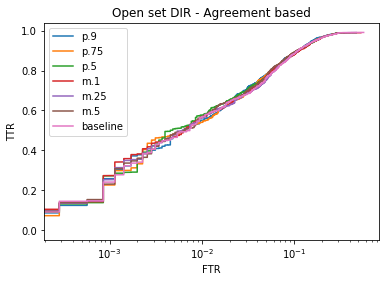

In [158]:
# TODO flip axis?
# TODO add a dash line for cieling?
plt.plot(p9_FTRs, p9_TTR, label='p.9')
plt.plot(p75_FTRs, p75_TTR, label='p.75')
plt.plot(p5_FTRs, p5_TTR, label='p.5')

plt.plot(m1_FTRs, m1_TTR, label='m.1')
plt.plot(m25_FTRs, m25_TTR, label='m.25')
plt.plot(m5_FTRs, m5_TTR, label='m.5')

plt.plot(baseline_FTRs, baseline_TTR, label='baseline')
plt.xlabel('FTR')
plt.ylabel('TTR')
#plt.ylim([0, .4])
plt.xscale('log')
#plt.xlim([1e-4, 1e-2])
plt.legend()
plt.title('Open set DIR - Agreement based')

Text(0.5,1,'Open set DIR - Agreement based')

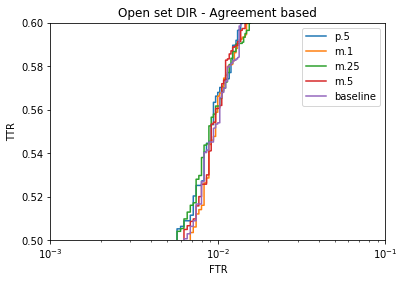

In [174]:
# TODO flip axis?
# TODO add a dash line for cieling?
#plt.plot(fuse_p9_FTRs, fuse_p9_TTR, label='p.9')
#plt.plot(fuse_p75_FTRs, fuse_p75_TTR, label='p.75')
plt.plot(fuse_p5_FTRs, fuse_p5_TTR, label='p.5')

plt.plot(fuse_m1_FTRs, fuse_m1_TTR, label='m.1')
plt.plot(fuse_m25_FTRs, fuse_m25_TTR, label='m.25')
plt.plot(fuse_m5_FTRs, fuse_m5_TTR, label='m.5')

plt.plot(fuse_baseline_FTRs, fuse_baseline_TTR, label='baseline')
plt.xlabel('FTR')
plt.ylabel('TTR')
plt.ylim([0.5, .6])
plt.xscale('log')
plt.xlim([1e-3, 1e-1])
plt.legend()
plt.title('Open set DIR - Agreement based')